In [1]:
import matplotlib.pyplot as plt
import sympy as sy
from pycqed import *

## Operator Basis Example

Here we show how to use different basis representations for the conjugate operator pairs and describe the motivations for doing so.

Currently two basis representations are available in PyCQED. In the charge basis, the charge operator associated with a node or branch describes the Cooper pair occupancy of that node or branch. The conjugate operator in the charge basis is the phase or flux operator, which quantizes the phase of a node or branch in terms of the flux quantum.

In a circuit composed of capacitors and inductors, the charge representation for the basis can be rather inefficient (explain). By eliminating inductive or capacitive couplings between operators (generally using coordinate transformations) it is possible to use an oscillator basis which more naturally describes the degrees of freedom of a node or branch, and can lead to a smaller Hilbert space size.

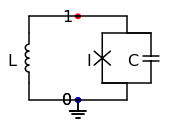

In [2]:
# Create the circuit
circuit = CircuitSpec("RF-SQUID Qubit Circuit")
circuit.addBranch(["L"],"up",0,False,arm_len=0.5)
circuit.addBranch(["I","C"],"down",1,True,arm_len=0.5)
circuit.drawCircuit(inline=True)

# Initialise a Hamiltonian in the charge basis
hamil1 = HamilSpec(circuit,mode="node")
hamil1.setTruncation(1,20,"charge")
hamil1.prepareOperators()

# Initialise a Hamiltonian in the oscillator basis
hamil2 = HamilSpec(circuit,mode="node")
hamil2.setTruncation(1,20,"osc")
hamil2.prepareOperators()

# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 3.0  # uA/um^2
Aj = 0.2*1.2#0.4**2 # um^2

# Set the parameter values
hamil1.setParameterValues(
    'C',Ca*Aj,
    'I',Jc*Aj,
    'L',570.0,
    'phi10e',0.5
)

# Set the parameter values
hamil2.setParameterValues(
    'C',Ca*Aj,
    'I',Jc*Aj,
    'L',570.0,
    'phi10e',0.5
)

In [3]:
spec = [
    hamil1.sweepSpec('phi10e',0.49,0.51,101)
#    hamil.sweepSpec('phi10e',-0.51,-0.49,101)
]
sweep1 = hamil1.paramSweep(spec,timesweep=True)
sweep2 = hamil2.paramSweep(spec,timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.070 s
  Loop duration:	0.856 s
  Avg iteration:	0.008 s
Parameter Sweep Duration:
  Initialization:	0.050 s
  Loop duration:	0.691 s
  Avg iteration:	0.007 s


In [4]:
x,E1,v = hamil1.getSweep(sweep1,'phi10e',{})
x,E2,v = hamil2.getSweep(sweep2,'phi10e',{})

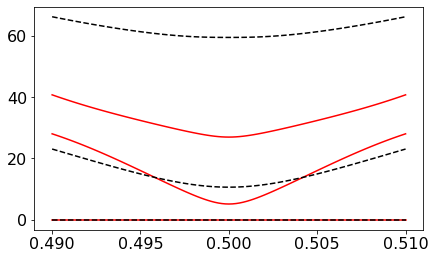

In [5]:
for i in range(3):
    plt.plot(x,E1[i]-E1[0],"r-")
for i in range(3):
    plt.plot(x,E2[i]-E2[0],"k--")

We see here that the spectrum using the oscillator basis has not converged for the given truncation. This is due to the nonlinear component of the oscillator provided by the Josephson junction. To fix this we need a higher truncation on the oscillator state. Currently the Hilbert space sizes are:

In [6]:
hamil1.getHilbertSpaceSize()

41

In [7]:
hamil2.getHilbertSpaceSize()

20

Now let's increase the oscillator basis truncation and rerun the sweep

In [8]:
hamil2.setTruncation(1,60,"osc")
hamil2.prepareOperators()
sweep2 = hamil2.paramSweep(spec,timesweep=True)
x,E2,v = hamil2.getSweep(sweep2,'phi10e',{})

Parameter Sweep Duration:
  Initialization:	0.111 s
  Loop duration:	1.352 s
  Avg iteration:	0.013 s


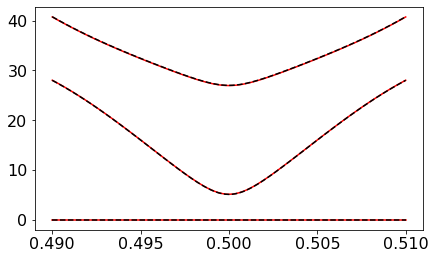

In [9]:
for i in range(3):
    plt.plot(x,E1[i]-E1[0],"r-")
for i in range(3):
    plt.plot(x,E2[i]-E2[0],"k--")

Now we see the energy spectrum has converged.

Associated with each oscillator operator pair is a characteristic frequency and impedance, which depend on elements of the circuit. The benefit of using the oscillator basis is the potential reduction in Hilbert space size. However when simulating against circuit component values, in general the conjugate operators need to be regenerated at each point.

The symbolic oscillator parameters associated with node 1 can be accessed as follows:

In [10]:
hamil2.osc_params

{1: {'frequency': 1.0*sqrt(1/(C_{}*L_{})), 'impedance': 1.0*sqrt(L_{}/C_{})}}

The values of the oscillator parameters are generated during a sweep or substition, and can be accessed as follows:

In [11]:
hamil2.Znp

{1: 198.9556064385554}

In [12]:
hamil2.wnp

{1: 55.552224948318965}

These values are in Ohms and GHz respectively.

## Circuit Operator Expectation Values

Here we show how to get operator expectation values.

## Operator Transformations

Here we describe the process for transforming the circuit Hamiltonian to make use of oscillator basis representations and for making BO approximations.

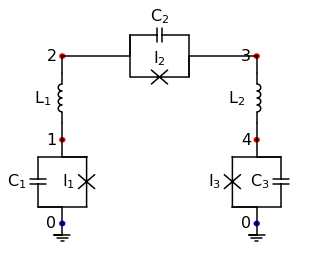

In [13]:
# Create the circuit
circuit = CircuitSpec("3JJ Qubit Circuit with Inductance")
circuit.addBranch(["I1","C1"],"up",0,False)
circuit.addBranch(["L1"],"up",1,False)
circuit.addBranch(["I2","C2"],"right",2,False,lead_len=2.0)
circuit.addBranch(["L2"],"down",3,False)
circuit.addBranch(["I3","C3"],"down",4,True)
circuit.drawCircuit(inline=True)

In [14]:
circuit.getCapacitanceMatrix()

Matrix([
[C_{1},      0,      0,     0],
[    0,  C_{2}, -C_{2},     0],
[    0, -C_{2},  C_{2},     0],
[    0,      0,      0, C_{3}]])

In [15]:
circuit.getInverseInductanceMatrix()

Matrix([
[ 1.0/L_{1}, -1.0/L_{1},          0,          0],
[-1.0/L_{1},  1.0/L_{1},          0,          0],
[         0,          0,  1.0/L_{2}, -1.0/L_{2}],
[         0,          0, -1.0/L_{2},  1.0/L_{2}]])

In [16]:
circuit.getQuantumHamiltonian()

Matrix([[-0.5*I_{1}*(1.0*D^{\dagger}_{1} + 1.0*D_{1}) - 0.5*I_{2}*(1.0*D^{\dagger}_{2}*D_{3} + 1.0*D_{2}*D^{\dagger}_{3}) - 0.5*I_{3}*(e^{i\phi_{40e}}*D_{4} + conjugate(e^{i\phi_{40e}})*D^{\dagger}_{4}) + (-0.125*Q_{2}/C_{2} + 0.125*Q_{3}/C_{2})*Q_{3} + (0.125*Q_{2}/C_{2} - 0.125*Q_{3}/C_{2})*Q_{2} + (-0.5*\Phi_{1}/L_{1} + 0.5*\Phi_{2}/L_{1})*\Phi_{2} + (0.5*\Phi_{1}/L_{1} - 0.5*\Phi_{2}/L_{1})*\Phi_{1} + (-0.5*\Phi_{3}/L_{2} + 0.5*\Phi_{4}/L_{2})*\Phi_{4} + (0.5*\Phi_{3}/L_{2} - 0.5*\Phi_{4}/L_{2})*\Phi_{3} + 0.5*Q_{4}**2/C_{3} + 0.5*Q_{1}**2/C_{1}]])

### Optimal Oscillator Modes

Here we use a transformation obtained from diagonalising the inductance matrix of the system to evaluate which conjugate operator pairs are suitable to represent in an oscillator basis:

In [17]:
P, D = circuit.getInverseInductanceMatrix().diagonalize(sort=False)

In [18]:
P

Matrix([
[1.0,   0, -1.0,    0],
[1.0,   0,  1.0,    0],
[  0, 1.0,    0, -1.0],
[  0, 1.0,    0,  1.0]])

In [19]:
D

Matrix([
[0, 0,         0,         0],
[0, 0,         0,         0],
[0, 0, 2.0/L_{1},         0],
[0, 0,         0, 2.0/L_{2}]])

In [20]:
P*D*P**(-1)

Matrix([
[ 1.0/L_{1}, -1.0/L_{1},          0,          0],
[-1.0/L_{1},  1.0/L_{1},          0,          0],
[         0,          0,  1.0/L_{2}, -1.0/L_{2}],
[         0,          0, -1.0/L_{2},  1.0/L_{2}]])

In [21]:
P**(-1)*circuit.getInverseInductanceMatrix()*P

Matrix([
[0, 0,         0,         0],
[0, 0,         0,         0],
[0, 0, 2.0/L_{1},         0],
[0, 0,         0, 2.0/L_{2}]])

We see that there are two eigenvalues for the diagonal inductance matrix, thus we expect to be able to use two oscillator modes. The transformation matrix we require is then:

In [22]:
R = P**(-1)

Formally the number of oscillator modes will be:

In [23]:
eig = D.eigenvals()

# Count the number of non-zero eigenvalues:
Nosc = 0
for e,m in eig.items():
    if e != 0:
        Nosc+=1
print (Nosc)

# Find the indices of the non-zero diagonal elements

2


The other modes can be separated into island and Josephson modes, where the former describe modes where the flux degree of freedom does not appear in the Hamiltonian, and the latter describe modes that are $\Phi_0$ periodic.

The number of island modes is:

In [24]:
eig

{0: 2, 2/L_{1}: 1, 2/L_{2}: 1}

In [25]:
# Find edges in the circuit graph that have no capacitors
Nisl = len(circuit.getNonCapacitiveEdges())
print (Nisl)

2


In [26]:
circuit.getNonCapacitiveEdges()

[(1, 2), (3, 4)]

The number of Josephson modes is then the remaining number of modes:

In [27]:
len(circuit.getNodeList()) - Nisl - Nosc

0

We then apply the transformations such that the commutation relations between each conjugate operator pair are preserved:

In [28]:
R*circuit.getFluxVector()

Matrix([
[ 0.5*\Phi_{1} + 0.5*\Phi_{2}],
[ 0.5*\Phi_{3} + 0.5*\Phi_{4}],
[-0.5*\Phi_{1} + 0.5*\Phi_{2}],
[-0.5*\Phi_{3} + 0.5*\Phi_{4}]])

In [29]:
(R.transpose())**(-1)*circuit.getChargeVector()

Matrix([
[ 1.0*Q_{1} + 1.0*Q_{2}],
[ 1.0*Q_{3} + 1.0*Q_{4}],
[-1.0*Q_{1} + 1.0*Q_{2}],
[-1.0*Q_{3} + 1.0*Q_{4}]])

These describe the new flux and charge vectors. From here we could make the decision to neglect the operator additions since they will likely have higher energy than those with differences. Now we can look at the new inverse capacitance and inductance matrices under these transformations:

In [30]:
circuit.getInverseCapacitanceMatrix()

Matrix([
[1/C_{1},            0,            0,       0],
[      0,  1/(4*C_{2}), -1/(4*C_{2}),       0],
[      0, -1/(4*C_{2}),  1/(4*C_{2}),       0],
[      0,            0,            0, 1/C_{3}]])

In [31]:
R*circuit.getInverseCapacitanceMatrix()*R.transpose()

Matrix([
[0.0625/C_{2} + 0.25/C_{1},             -0.0625/C_{2}, 0.0625/C_{2} - 0.25/C_{1},              0.0625/C_{2}],
[            -0.0625/C_{2}, 0.25/C_{3} + 0.0625/C_{2},             -0.0625/C_{2}, 0.25/C_{3} - 0.0625/C_{2}],
[0.0625/C_{2} - 0.25/C_{1},             -0.0625/C_{2}, 0.0625/C_{2} + 0.25/C_{1},              0.0625/C_{2}],
[             0.0625/C_{2}, 0.25/C_{3} - 0.0625/C_{2},              0.0625/C_{2}, 0.25/C_{3} + 0.0625/C_{2}]])

In [32]:
(R.transpose())**(-1)*circuit.getInverseInductanceMatrix()*R**(-1)

Matrix([
[0, 0,         0,         0],
[0, 0,         0,         0],
[0, 0, 4.0/L_{1},         0],
[0, 0,         0, 4.0/L_{2}]])

In [33]:
Linv_new = (R.transpose())**(-1)*circuit.getInverseInductanceMatrix()*R**(-1)
Cinv_new = R*circuit.getInverseCapacitanceMatrix()*R.transpose()
Phi_new = R*circuit.getFluxVector()
Q_new = (R.transpose())**(-1)*circuit.getChargeVector()

In [34]:
(0.5*Phi_new.transpose()*Linv_new*Phi_new).expand()

Matrix([[-0.5*\Phi_{3}*\Phi_{4}/L_{2} + 0.5*\Phi_{3}**2/L_{2} - 0.5*\Phi_{4}*\Phi_{3}/L_{2} + 0.5*\Phi_{4}**2/L_{2} - 0.5*\Phi_{1}*\Phi_{2}/L_{1} + 0.5*\Phi_{1}**2/L_{1} - 0.5*\Phi_{2}*\Phi_{1}/L_{1} + 0.5*\Phi_{2}**2/L_{1}]])

According to the diagonal inductance matrix, the two oscillator modes will be the last two coordinates, and the first two are island modes.

In [35]:
Phi_new_r = Phi_new.subs({Phi_new[0]:0.5*sy.symbols('\\Phi_{I1}'),Phi_new[1]:0.5*sy.symbols('\\Phi_{I2}'),Phi_new[2]:0.5*sy.symbols('\\Phi_{O1}'),Phi_new[3]:0.5*sy.symbols('\\Phi_{O2}')})
Q_new_r = Q_new.subs({Q_new[0]:sy.symbols('Q_{I1}'),Q_new[1]:sy.symbols('Q_{I2}'),Q_new[2]:sy.symbols('Q_{O1}'),Q_new[3]:sy.symbols('Q_{O2}')})

So we have renamed

In [36]:
Phi_new

Matrix([
[ 0.5*\Phi_{1} + 0.5*\Phi_{2}],
[ 0.5*\Phi_{3} + 0.5*\Phi_{4}],
[-0.5*\Phi_{1} + 0.5*\Phi_{2}],
[-0.5*\Phi_{3} + 0.5*\Phi_{4}]])

and

In [37]:
Q_new

Matrix([
[ 1.0*Q_{1} + 1.0*Q_{2}],
[ 1.0*Q_{3} + 1.0*Q_{4}],
[-1.0*Q_{1} + 1.0*Q_{2}],
[-1.0*Q_{3} + 1.0*Q_{4}]])

to

In [38]:
Phi_new_r

Matrix([
[0.5*\Phi_{I1}],
[0.5*\Phi_{I2}],
[0.5*\Phi_{O1}],
[0.5*\Phi_{O2}]])

and

In [39]:
Q_new_r

Matrix([
[Q_{I1}],
[Q_{I2}],
[Q_{O1}],
[Q_{O2}]])

In [40]:
0.5*(Phi_new_r.transpose()*Linv_new*Phi_new_r).expand()

Matrix([[0.5*\Phi_{O2}**2/L_{2} + 0.5*\Phi_{O1}**2/L_{1}]])

In [41]:
0.5*(Q_new_r.transpose()*Cinv_new*Q_new_r)

Matrix([[0.5*Q_{I1}*(Q_{I1}*(0.0625/C_{2} + 0.25/C_{1}) + Q_{O1}*(0.0625/C_{2} - 0.25/C_{1}) - 0.0625*Q_{I2}/C_{2} + 0.0625*Q_{O2}/C_{2}) + 0.5*Q_{I2}*(Q_{I2}*(0.25/C_{3} + 0.0625/C_{2}) + Q_{O2}*(0.25/C_{3} - 0.0625/C_{2}) - 0.0625*Q_{I1}/C_{2} - 0.0625*Q_{O1}/C_{2}) + 0.5*Q_{O1}*(Q_{I1}*(0.0625/C_{2} - 0.25/C_{1}) + Q_{O1}*(0.0625/C_{2} + 0.25/C_{1}) - 0.0625*Q_{I2}/C_{2} + 0.0625*Q_{O2}/C_{2}) + 0.5*Q_{O2}*(Q_{I2}*(0.25/C_{3} - 0.0625/C_{2}) + Q_{O2}*(0.25/C_{3} + 0.0625/C_{2}) + 0.0625*Q_{I1}/C_{2} + 0.0625*Q_{O1}/C_{2})]])

In [42]:
Dl = circuit.getLeftDisplacementOpMatrix()
Dla = circuit.getLeftDisplacementOpMatrix(adjoint=True)
Dr = circuit.getRightDisplacementOpVector()
Dra = circuit.getRightDisplacementOpVector(adjoint=True)
Fm = circuit.getFluxBiasMatrix(mode="branch",form="expphase")
J = circuit.getJosephsonVector().transpose()
J*(Fm*Dl*Dr+Fm.conjugate()*Dla*Dra)

Matrix([[I_{1}*(1.0*D^{\dagger}_{1} + 1.0*D_{1}) + I_{2}*(1.0*D^{\dagger}_{2}*D_{3} + 1.0*D_{2}*D^{\dagger}_{3}) + I_{3}*(e^{i\phi_{40e}}*D_{4} + conjugate(e^{i\phi_{40e}})*D^{\dagger}_{4})]])

In [45]:
Dl

Matrix([
[1,     0,     0,     0,     0],
[0, D_{1},     0,     0,     0],
[0,     0, D_{2},     0,     0],
[0,     0,     0, D_{3},     0],
[0,     0,     0,     0, D_{4}]])

In [53]:
list(Phi_new[0].atoms())

[\Phi_{1}, \Phi_{2}, 0.500000000000000]

In [54]:
list(Phi_new[1].atoms())

[\Phi_{4}, 0.500000000000000, \Phi_{3}]

In [66]:
prefactors = [1.0]*len(Phi_new)
for i,elem in enumerate(Phi_new.simplify()):
    atoms = list(elem.atoms())
    for atom in atoms:
        if type(atom) is sy.Float:
            prefactors[i] = float(atom)
print (prefactors)

[0.5, 0.5, 0.5, 0.5]


In [72]:
Q_new.simplify()[3].args

(Q_{4}, -1.0*Q_{3})

In [62]:
for elem in Q_new.simplify():
    atoms = list(elem.atoms())
    print (atoms)
    for atom in atoms:
        if type(atom) is sy.Float:
            print ("Found %f" % atom)

[Q_{2}, Q_{1}]
[Q_{3}, Q_{4}]
[-1.00000000000000, Q_{2}, Q_{1}]
Found -1.000000
[-1.00000000000000, Q_{3}, Q_{4}]
Found -1.000000


In [63]:
Q_new.simplify()

Matrix([
[     Q_{1} + Q_{2}],
[     Q_{3} + Q_{4}],
[-1.0*Q_{1} + Q_{2}],
[-1.0*Q_{3} + Q_{4}]])

In [95]:
# Get symbolic expression prefactor
def _get_trans_vect_prefs(circuit):
    Phi_prefactors = [1.0]*len(Phi_new)
    Q_prefactors = [1.0]*len(Q_new)
    for i,elem in enumerate(Phi_new.simplify()):
        atoms = list(elem.atoms())
        for atom in atoms:
            if type(atom) is sy.Float:
                Phi_prefactors[i] = float(atom)
    return Phi_prefactors

# Apply transformation
def autoTransform(circuit):
    
    # Get the diagonal inductance matrix
    P, D = circuit.getInverseInductanceMatrix().diagonalize()
    
    # Select the transformation matrix
    R = P**(-1)
    
    # Count the number of non-zero eigenvalues:
    Nosc = 0
    eig = D.eigenvals()
    for e,m in eig.items():
        if e != 0:
            Nosc+=1
    
    # Find edges in the circuit graph that have no capacitors
    Nisl = len(circuit.getNonCapacitiveEdges())
    
    # Find the number of Josephson modes
    Njos = len(circuit.getNodeList()) - Nisl - Nosc
    
    # Get the new component matrices
    Linv = D
    Cinv = R*circuit.getInverseCapacitanceMatrix()*R.transpose()
    
    # Transform the coordinate vectors
    Phi = R*circuit.getFluxVector()
    Q = (R.transpose())**(-1)*circuit.getChargeVector()
    
    # Extract the prefactors
    Phi_prefactors = [1.0]*len(Phi)
    Q_prefactors = [1.0]*len(Q)
    for i,elem in enumerate(Phi.simplify()):
        atoms = list(elem.atoms())
        for atom in atoms:
            if type(atom) is sy.Float:
                Phi_prefactors[i] = float(atom)
    for i,elem in enumerate(Q.simplify()):
        atoms = list(elem.atoms())
        for atom in atoms:
            if type(atom) is sy.Float:
                Q_prefactors[i] = float(atom)
    
    return Linv,Cinv,Nosc,Nisl,Njos,Phi,Q,Phi_prefactors,Q_prefactors
    

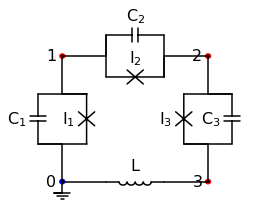

In [86]:
# Create the circuit
circuit = CircuitSpec("3JJ Qubit Circuit with Inductance")
circuit.addBranch(["I1","C1"],"up",0,False,lead_len=1.5)
circuit.addBranch(["I2","C2"],"right",1,False,lead_len=1.5)
circuit.addBranch(["I3","C3"],"down",2,False,lead_len=1.5)
circuit.addBranch(["L"],"left",3,False,lead_len=1.5)
circuit.drawCircuit(inline=True)

In [87]:
circuit.getCapacitanceMatrix()

Matrix([
[C_{1} + C_{2},        -C_{2},      0],
[       -C_{2}, C_{2} + C_{3}, -C_{3}],
[            0,        -C_{3},  C_{3}]])

In [88]:
circuit.getInductanceMatrix()

Matrix([
[0, 0,        0],
[0, 0,        0],
[0, 0, 1.0*L_{}]])

In [107]:
circuit.getInverseCapacitanceMatrix()

Matrix([
[1/C_{1},                       1/C_{1},                       1/C_{1}],
[1/C_{1}, (C_{1} + C_{2})/(C_{1}*C_{2}), (C_{1} + C_{2})/(C_{1}*C_{2})],
[1/C_{1}, (C_{1} + C_{2})/(C_{1}*C_{2}),   1/C_{3} + 1/C_{2} + 1/C_{1}]])

In [96]:
Linv,Cinv,Nosc,Nisl,Njos,Phi,Q,Phi_prefactors,Q_prefactors = autoTransform(circuit)

In [97]:
Linv

Matrix([
[0, 0,      0],
[0, 0,      0],
[0, 0, 1/L_{}]])

In [98]:
Cinv

Matrix([
[1.0/C_{1},                         1.0/C_{1},                         1.0/C_{1}],
[1.0/C_{1}, 1.0*(C_{1} + C_{2})/(C_{1}*C_{2}), 1.0*(C_{1} + C_{2})/(C_{1}*C_{2})],
[1.0/C_{1}, 1.0*(C_{1} + C_{2})/(C_{1}*C_{2}), 1.0/C_{3} + 1.0/C_{2} + 1.0/C_{1}]])

In [99]:
Nosc

1

In [100]:
Nisl

1

In [101]:
Njos

1

In [102]:
Q

Matrix([
[1.0*Q_{1}],
[1.0*Q_{2}],
[1.0*Q_{3}]])

In [103]:
Phi

Matrix([
[1.0*\Phi_{1}],
[1.0*\Phi_{2}],
[1.0*\Phi_{3}]])

In [104]:
Phi_prefactors

[1.0, 1.0, 1.0]

In [105]:
Q_prefactors

[1.0, 1.0, 1.0]